# TP1: Checkpoint 2
## Modelo 1

In [1]:
!pip install 'dtreeviz'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.7 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-05 23:04:32--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv’

hotels_train.csv    100%[===================>]   9.33M  --.-KB/s    in 0.06s   

2023-10-05 23:04:33 (151 MB/s) - ‘hotels_train.csv’ saved [9788953/9788953]



In [3]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-05 23:04:33--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv’

hotels_test.csv     100%[===================>]   4.23M  --.-KB/s    in 0.03s   

2023-10-05 23:04:34 (131 MB/s) - ‘hotels_test.csv’ saved [4432981/4432981]



In [4]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [5]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

In [6]:
df.head(3)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,No Deposit,9.0,NaN,0,Transient,229.0,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0


# Modificando el dataset

In [7]:
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop('company', axis=1)

In [8]:
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)
print(f'Nueva media: {df_filtrado.children.mean().round(6)}\nNueva Moda:  {df_filtrado.children.mode()}\n')

Nueva media: 0.104889
Nueva Moda:  0    0.0
Name: children, dtype: float64



In [9]:
moda_vieja = df.agent.mode()
df_filtrado.agent = df_filtrado.agent.replace(np.nan, 9)
moda_nueva = df.agent.mode()
print(f'Moda Vieja: {moda_vieja}\nModa Nueva: {moda_nueva}')

Moda Vieja: 0    9.0
Name: agent, dtype: float64
Moda Nueva: 0    9.0
Name: agent, dtype: float64


In [10]:
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [11]:
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)

In [12]:
df_filtrado = df_filtrado.replace({'children': 10}, value=0)

In [13]:
df_filtrado = df_filtrado.replace({'babies': 9}, value=0)

In [14]:
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=df_filtrado['adr'].median())

In [15]:
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].median())

## Sumamos cambios a nuestro dataframe de la primera parte.

Hay demasiado paises y algunos que solo tienen una aparición en reservas, lo cual va a crear demasiadas columnas innecesarias para nuestro dataset, vamoa a probar cambiando algunas por la moda, a continuación nuestro minusioso analisis.

In [16]:
df_filtrado["country"].value_counts()

PRT    28171
GBR     5733
FRA     4809
ESP     4210
DEU     3312
       ...  
HND        1
FJI        1
LIE        1
ATA        1
RWA        1
Name: country, Length: 149, dtype: int64

In [17]:
df_paises_unicos = df_filtrado['country'].value_counts().reset_index()
df_paises_unicos.columns = ['country', 'Conteo']

umbral = 50

resultado = df_paises_unicos[df_paises_unicos['Conteo'] < umbral]
print(f"La cantidad de paises que tiene menos de {umbral} reservas es {resultado.shape[0]}, siendo un total de {resultado.Conteo.sum()} casos")

La cantidad de paises que tiene menos de 50 reservas es 112, siendo un total de 1253 casos


# Encoding and separation columns

Usando una prroporción de 70 y 30 separo mi dataset en train y validation, con una semilla = 2.

In [18]:
df_filtrado.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,D,0,No Deposit,9.0,0,Transient,115.5,0,1,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,A,0,No Deposit,9.0,0,Transient,42.0,1,0,0


In [19]:
ds_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)
ds_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,37,5,1,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4,2015,44,31,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,42,13,0,1,2,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
ds_trabajo_x=ds_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

ds_trabajo_y = ds_encodeado['is_canceled'].copy()

x_train, x_valid, y_train, y_valid = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=20)

#Busqueda de hiperparametros

In [21]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini', 'entropy'],
               'min_samples_leaf':list(range(1,4)),
               'min_samples_split': list(range(2,10)),
               'ccp_alpha':np.linspace(0,0.001,10),
               'max_depth':list(range(14,16))}


#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [22]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'gini', 'ccp_alpha': 0.00011111111111111112}
0.8530669350674541


aca abajo copie y pegue tal cual el entrenamiento y prediccion, solo por no querer tocarlo

In [23]:
tree_model = tree.DecisionTreeClassifier(criterion=randomcv.best_params_['criterion'],
                                         max_depth = randomcv.best_params_['max_depth'],
                                         ccp_alpha=randomcv.best_params_['ccp_alpha'],
                                         min_samples_leaf=randomcv.best_params_['min_samples_leaf'],
                                         min_samples_split=randomcv.best_params_['min_samples_split'])
#Entrenamos el modelo
model = tree_model.fit(X = x_train.sort_index(axis=1), y = y_train)

In [24]:
y_pred = model.predict(x_valid.sort_index(axis=1))
#Valores Predichos
y_pred

array([1, 1, 1, ..., 1, 0, 0])

In [25]:
y_valid.values

array([1, 1, 1, ..., 1, 1, 0])

In [26]:
ds_resultados=pd.DataFrame(zip(y_valid,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,1,1
1,1,1
2,1,1
3,0,0
4,1,1
5,1,1
6,1,1
7,0,0
8,1,1
9,1,1


Text(50.722222222222214, 0.5, 'True')

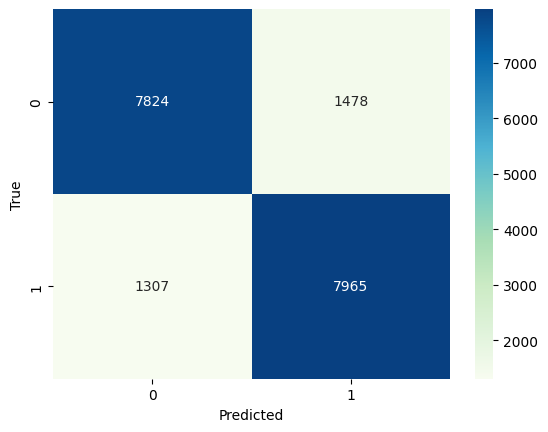

In [27]:
tabla=confusion_matrix(y_valid, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [28]:
accuracy=accuracy_score(y_valid,y_pred)
recall=recall_score(y_valid,y_pred)
f1=f1_score(y_valid,y_pred,)
precision=precision_score(y_valid,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8500592225691828
Recall: 0.8590379637618637
Precision: 0.8434819442973631
f1 score: 0.8511888859203848


In [29]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      9302
           1       0.84      0.86      0.85      9272

    accuracy                           0.85     18574
   macro avg       0.85      0.85      0.85     18574
weighted avg       0.85      0.85      0.85     18574



# Test prediction

## Modificando el Dataset

In [30]:
df_test = pd.read_csv("hotels_test.csv")

df_test_filtrado = df_test.copy()

In [31]:
df_test_filtrado['reservation_status_date']

0        2016-04-04
1        2016-01-22
2        2016-08-24
3        2016-11-05
4        2016-10-18
            ...    
26530    2017-04-26
26531    2016-09-06
26532    2016-08-04
26533    2017-03-07
26534    2016-03-27
Name: reservation_status_date, Length: 26535, dtype: object

In [32]:
df_test_ids = df_test['id']
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('company', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [33]:
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'PRT')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, 9)
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)

In [34]:
df_test_filtrado.isna().any()

hotel                             False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                             False
days_in_waiting_list              False
customer_type                     False


In [35]:
df_test_paises_unicos = df_test_filtrado['country'].value_counts().reset_index()
df_test_paises_unicos.columns = ['country', 'Conteo']

umbral = 8

resultado = df_test_paises_unicos[df_test_paises_unicos['Conteo'] < umbral]
print(f"La cantidad de paises que tiene menos de {umbral} reservas es {resultado.shape[0]}, siendo un total de {resultado.Conteo.sum()} casos")

La cantidad de paises que tiene menos de 8 reservas es 69, siendo un total de 173 casos


Eliminando paises que no aparecen en el train, reemplazandolos por la moda PRT

In [36]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="PRT")

['DJI', 'UZB', 'BFA', 'SLV', 'NIC', 'ATF', 'KHM', 'MLI', 'ASM', 'SMR', 'DMA', 'TMP']


adr = 0


In [37]:
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())

0 adultos

In [38]:
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)

In [39]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=True)


## Prediccion

Viendo las columnas que no se encuentran en el dataset de Test, agregandolas y seteandolas a cero.

In [40]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in ds_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

country_ARM
country_AZE
country_BEN
country_CIV
country_COM
country_ETH
country_FJI
country_FRO
country_GTM
country_HND
country_KEN
country_KNA
country_MDG
country_MNE
country_MUS
country_MYT
country_NAM
country_PAN
country_PYF
country_SDN
country_SYC
country_SYR
country_TGO
country_UMI
country_VGB
country_ZMB
market_segment_Undefined
distribution_channel_Undefined
assigned_room_type_L


In [41]:
test_pred_2 = model.predict(df_test_encodeado.sort_index(axis=1))
#Valores Predichos
test_pred_2

array([1, 1, 0, ..., 1, 1, 0])

In [42]:
# Crear un DataFrame con las columnas "id" e "is_canceled"
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [43]:
df_final_finalisimo.isna().any()

id             False
is_canceled    False
dtype: bool

In [44]:
df_final_finalisimo.head(10)

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
5,c142b61c-3035-46e7-8cf7-3720a29d0d61,1
6,8c4171ad-9837-4468-ac8e-8cb3d5a41b55,0
7,3ce60033-4529-4314-be77-db4a7737f326,1
8,7ab807a4-5e90-4205-b66e-0188696cc34b,0
9,a0ab0509-c8b0-4a2c-9f27-21f26e186520,0


In [45]:
df_final_finalisimo.to_csv('submission.csv', index=False)

# Graficando el Arbol

In [46]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model,
                                feature_names=df_test_encodeado.columns.to_list(),
                                filled=True,
                                rounded=True,
                                class_names=['No Cancelado','Cancelado'],
                                 max_depth = 3) #model.classes_
plt.show(tree_plot_completo)